In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import genpareto
matplotlib.use('TkAgg')

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import trange, tqdm
#from anomaly_scoring import get_anomaly_scores

import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline 

import utils
from utils import get_taxi_data_VAE, get_taxi_data_cVAE
from utils import softclip
from utils import plot_train_test_reconstructions, plot_train_test_reconstructions_prob_decoder_model
from models.cnn_sigmaVAE import CNN_sigmaVAE

import evaluation_utils

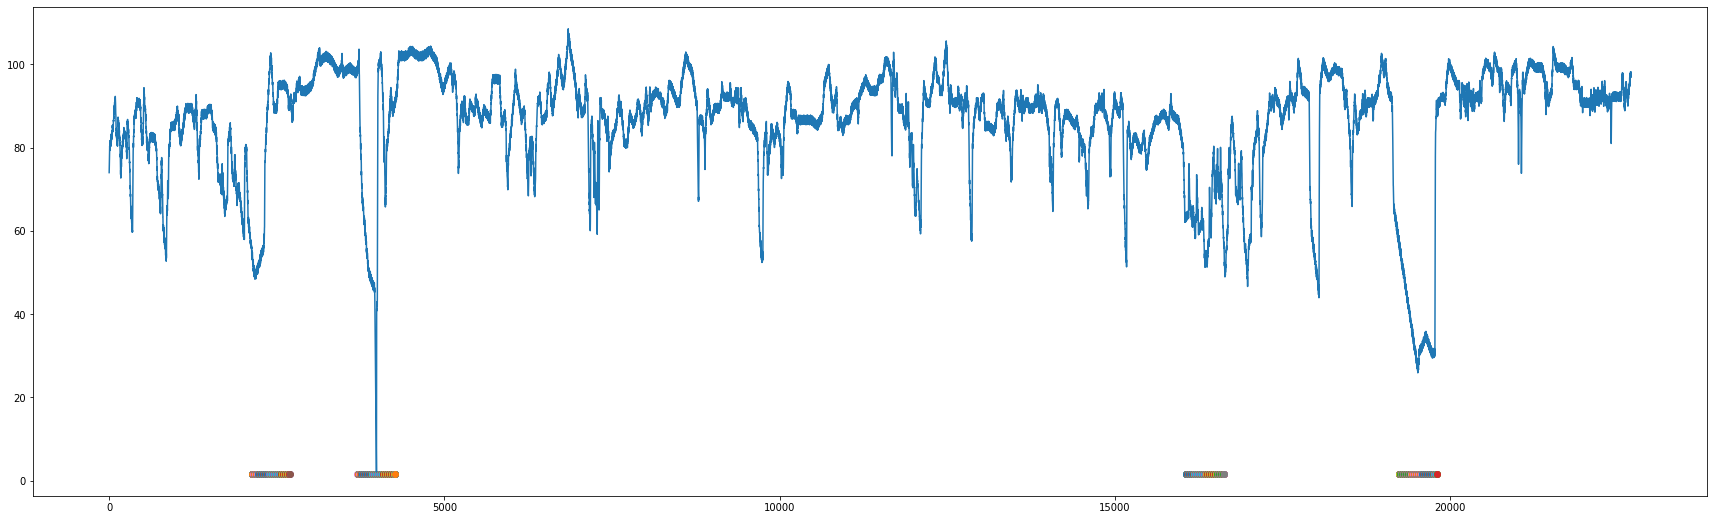

In [2]:
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/nyc_taxi.csv'
dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/machine_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ambient_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/cpu_utilization_asg_misconfiguration.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ec2_request_latency_system_failure.csv'

anomaly_timestamps, anomaly_windows = utils.get_anomaly_timestamps_and_windows(dataset_path)

    
#singular anomaly points
'''
window_size=32
X_train_data, X_test_data, X_train_tensor, X_test_tensor, trainloader, testloader = get_taxi_data_VAE(dataset_path,window_size=window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])
    
anomaly_idxs = []
for timestamp in anomaly_timestamps:
    start = timestamp

    loc_start = timestamps.index(start)
    anomaly_idxs.append(loc_start)
    
anomaly_idxs = np.array(anomaly_idxs)    
'''



#anomaly windows code -- not used currently -- what are anomaly windows in nab??

window_size=32
X_train_data, X_test_data, X_train_tensor, X_test_tensor, trainloader, testloader = get_taxi_data_VAE(dataset_path,window_size=window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])

anomaly_idxs = []
for timestamp in anomaly_windows:
    start, end = timestamp[0], timestamp[1]

    loc_start = timestamps.index(start)
    loc_end = timestamps.index(end)

    for i in range(loc_start, loc_end):
        anomaly_idxs.append(i)

anomaly_idxs = np.array(anomaly_idxs)
anomaly_idxs = anomaly_idxs[anomaly_idxs > 0]

plt.figure(figsize=(30,9))
for ai in anomaly_idxs:
    plt.scatter(ai, 1.7)


plt.plot(data['value'])
plt.show()


In [3]:
def train_model(model, num_epochs, learning_rate, dataloader):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=num_epochs
    tq = tqdm(range(epochs))
    
    losses = []
    
    for epoch in tq:
        flag = False
        for j, data in enumerate(dataloader, 0):

            model.train()
            
            optimizer.zero_grad()

            #batches
            inputs, labels = data
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs.cpu()
            inputs.to(device)
            labels = labels.cuda() if torch.cuda.is_available() else labels.cpu()
            labels.to(device)

            outputs, rec_mu, rec_sigma, kl = model(inputs)

            rec_comps, rec, rec_mu_sigma_loss, kl = model.loss_function(outputs, labels, rec_mu, rec_sigma, kl)

            loss = rec + kl + rec_mu_sigma_loss

            if(np.isnan(loss.item())):
                print("Noped out at", epoch, j, kl, rec_comps)
                flag = True
                break

            loss.backward()
            optimizer.step()
        if(flag):
            break
        tq.set_postfix(loss=loss.item())
        #print(epoch, 'total :' + str(loss.item()) + ' rec : ' + str(rec.item()) + ' kl : ' + str(kl.sum().item()) + ' sigma: ' + str(model.log_sigma.item()))

        losses.append(loss)
        
        #break
        
    plt.plot(losses)
    plt.show()
    
    return model

In [4]:
latent_dim=8
model = CNN_sigmaVAE(latent_dim=latent_dim, window_size=window_size, use_probabilistic_decoder=False)
model.to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()

model = train_model(model, 2000, .005, trainloader)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-f2bae1512cf1>", line 6, in <module>
    model = train_model(model, 2000, .005, trainloader)
  File "<ipython-input-3-737e59af4bf6>", line 35, in train_model
    loss.backward()
  File "c:\python37\lib\site-packages\torch\tensor.py", line 195, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "c:\python37\lib\site-packages\torch\autograd\__init__.py", line 99, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\python37\lib\site-packages\IPython\core\interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute 

KeyboardInterrupt: 

In [ ]:
plot_train_test_reconstructions(model, X_train_tensor, X_train_data, X_test_tensor,X_test_data) 

# Evaluation

In [ ]:
evaluation_utils.VAE_anomaly_detection(model, X_test_tensor, X_test_data, X_train_data, anomaly_idxs, .05)

# Probabilistic decoder

In [ ]:
latent_dim=8
model = CNN_sigmaVAE(latent_dim=latent_dim, window_size=window_size, use_probabilistic_decoder=True)
model.to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()

model = train_model(model, 1000, .005, trainloader)

In [ ]:
print(X_test_tensor.shape)
print(X_train_tensor.shape)

plot_train_test_reconstructions_prob_decoder_model(model, X_train_tensor, X_train_data, X_test_tensor,X_test_data) 

In [ ]:
evaluation_utils.VAE_prob_decoder_anomaly_detection(model, X_test_tensor, X_test_data, X_train_data, anomaly_idxs, .05)
